# Precision recall e ROC

### ROC
TruePositiveRate = TruePositives / (TruePositives + False Negatives)   (RECALL)

FalsePositiveRate = FalsePositives / (FalsePositives + TrueNegatives)

<img src="ROC-Curve.jpg" width=600 height=600 />

### Precision Recall
Precision = TruePositives / (TruePositives + FalsePositives)

Recall = TruePositives / (TruePositives + FalseNegatives)

<img src="Precision-Recall-Curve.jpg" width=600 height=600 />

<img src="Precisionrecall.svg" width=300 height=300 />

https://sinyi-chou.github.io/classification-pr-curve/
#

When data is imbalanced, the AUC might not reflect the true performance of the classifier. The definition of the False Positive Rate (FPR), is the number of false positives divided by the number of negative samples. FPR is considered better when it’s smaller since it indicates fewer false positives. In imbalanced data, the FPR tends to stay at small values due to the large numbers of negatives (i.e. making the denominator large). Thus, FPR becomes less informative for the model performance in this situation.  - 
#### La FPR rimane piccola a causa dello sbilanciamento, non a causa della bont del modello

# Instrinsic Dimension

In [1]:
import skdim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# generate data : np.array (n_points x n_dim). Here a uniformly sampled 5-ball embedded in 10 dimensions
dims = (1000,10)
data = np.zeros(dims)
data2 = np.ones(dims)
data_ball = data.copy()
data_ball[:,:5] = skdim.datasets.hyperBall(n = 1000, d = 5, radius = 1, random_state = 0)
data_ball2 = data2.copy()
data_ball2[:,:5] = skdim.datasets.hyperBall(n = 1000, d = 5, radius = 1, random_state = 0)

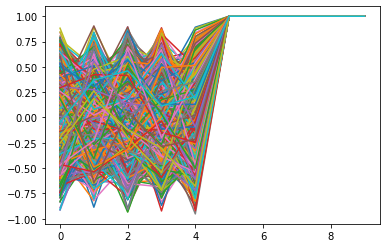

In [3]:
plt.plot(data_ball2.T);

In [7]:
#estimate global intrinsic dimension
danco = skdim.id.DANCo().fit(data_ball)
metodo = skdim.id.TwoNN()
#estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
lpca = skdim.id.lPCA().fit_pw(data_ball, n_neighbors = 100, n_jobs = 1)

#get estimated intrinsic dimension
print(round(danco.dimension_,2), round(np.mean(lpca.dimension_pw_),2))

4.96 5.0


In [4]:
metodo.fit(data_ball).dimension_, metodo.fit(data_ball2).dimension_

(4.626589720639767, 4.626589720639767)

In [8]:
def calc(d=1000):
    dims = (d,32)
    data3 = np.ones(dims)
    data_ball3 = data3.copy()
    data_ball3[:,:2] = skdim.datasets.hyperBall(n = d, d = 2, radius = 1, random_state = 0)
    res = metodo.fit(data_ball)
    print(res.dimension_)

In [24]:
calc(12)

4.626589720639767


In [4]:
emb_array = np.load("emb_array.npy")

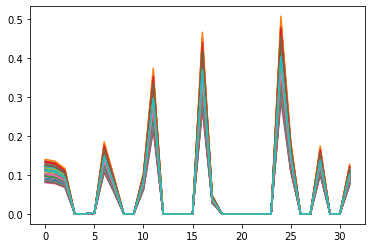

In [5]:
plt.plot(emb_array.T);

In [9]:
metodo.fit(emb_array)

mu: [1.00000000e+00 1.00000000e+00 1.00000262e+00 1.00000274e+00
 1.00000453e+00 1.00000846e+00 1.00000989e+00 1.00001562e+00
 1.00001884e+00 1.00001919e+00 1.00003421e+00 1.00191963e+00
 1.00615692e+00 1.00630927e+00 1.01112437e+00 1.03391445e+00
 1.04813123e+00 1.06887054e+00 1.09287345e+00 1.11436796e+00
 1.11776614e+00 1.12878001e+00 1.14790356e+00 1.15946531e+00
 1.17100346e+00 1.20315349e+00 1.24335921e+00 1.33967757e+00
 1.43432784e+00 1.43804467e+00 1.44501364e+00 1.53439975e+00
 1.55812871e+00 1.56353521e+00 1.64852667e+00 1.70138049e+00
 1.73647940e+00 1.73962903e+00 1.76634610e+00 1.81577623e+00
 1.87152660e+00 1.89030290e+00 1.97527456e+00 1.97922683e+00
 2.02961326e+00 2.10485888e+00 2.15153790e+00 2.28163695e+00
 2.35780931e+00 2.40396786e+00 2.40451241e+00 2.43292117e+00
 2.44666123e+00 2.53863597e+00 2.76100302e+00 3.97492146e+00
 4.00000000e+00 1.20981321e+01 1.28391676e+01 2.95672340e+01
 3.00968800e+01 1.32431543e+04 1.32433623e+04 1.33865459e+04
 1.33870049e+04 2.29

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Ho dovuto aggungere questa riga nel file _TwoNN.py per gestire questo problema che capita non so perchee con alcuni embeddings

mu = np.nan_to_num(mu, nan=0.000000001, posinf=9999999999, neginf=9999999999)


# Clustering coefficient

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from time import time

In [112]:


def cc_einsum(m):
    np.fill_diagonal(m,0)
    denom = np.einsum('ij,ki->i',m,m)
    correzione = np.einsum('ij,ji->i',m,m)
    d = (denom - correzione)
    num = np.einsum('ij,jk,ki->i',m,m,m)    
    
    #cc = num / d
    #cc[np.isnan(cc)] = 0  # nel caso di denom == 0
    
    # Use numpy.divide() to handle division by zero directly
    cc = np.divide(num, d, out=np.zeros_like(num), where=d!=0)
    
    return cc

def cc_networkx(adj):
    np.fill_diagonal(adj,0)
    g = nx.from_numpy_array(adj)
    cc = dict(nx.clustering(g)).values()
    return list(cc)

def cc_for(m):
    N = m.shape[0]
    cc_list = []
    
    for i in range(N):
        n = 0
        d = 0
        for j in range(N):
            for k in range(N):
                if j != i and k != i and k != j:
                    n += m[i][j]*m[j][k]*m[k][i]
                    d += m[i][j]*m[k][i]
        
        # Handle division by zero
        if d == 0:
            cc_list.append(0)
        else:
            cc_list.append(n/d)
    return cc_list

def genera_matrici(num_nodes, num_grafi):
    matrici = np.random.rand(num_grafi, num_nodes, num_nodes)
    adjs = np.array([np.random.binomial(1, m) for m in matrici])
    adjs_symm = np.array([(b + b.T)/2 for b in adjs]) < 0.5
    return adjs_symm.astype(int)

def genera_ER(num_nodes, num_grafi):
    p = 0.5
    return np.array([nx.to_numpy_array(nx.erdos_renyi_graph(num_nodes, p)) for i in range(num_grafi)])
    
            
def cc_vs_nodes(num_nodes, num_grafi=5):
    adjs = genera_matrici(num_nodes, num_grafi)
    #adjs = genera_ER(num_nodes, num_grafi)
    cc_list = [cc_networkx(adj) for adj in adjs]
    cc_list_ein = [cc_einsum(adj) for adj in adjs]
    cc_list_for = [cc_for(adj) for adj in adjs]
    return np.sum(np.array(cc_list) - np.array(cc_list_ein)), np.sum(np.array(cc_list_for) - np.array(cc_list_ein))

In [97]:
[cc_vs_nodes(n) for n in range(5,50,10)]

/tmp/ipykernel_37145/80301304.py:7: RuntimeWarning: invalid value encountered in divide
  cc = num / d


[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]

In [130]:
adjs = genera_ER(800, 2)
print(adjs.shape)

(2, 800, 800)


In [131]:
start = time()
cc_list = [cc_networkx(adj) for adj in adjs]
end = time()
print(round(end-start, 2)) 

23.14


In [132]:
start = time()
cc_list_ein = [cc_einsum(adj) for adj in adjs]
end = time()
print(round(end-start, 2))

2.73


In [142]:
cc_list_ein[0].shape

(800,)

In [106]:
start = time()
cc_list_for = [cc_for(adj) for adj in adjs]
end = time()
print(round(end-start, 2))

261.86


In [107]:
np.allclose(cc_list_for, cc_list_ein)
np.sum(np.array(cc_list_for) - np.array(cc_list_ein))

0.0

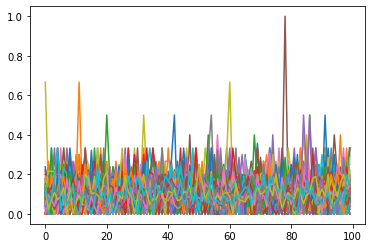

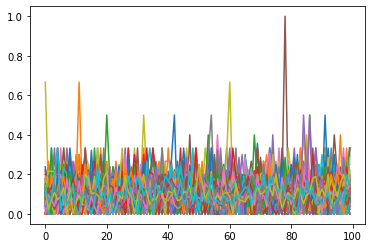

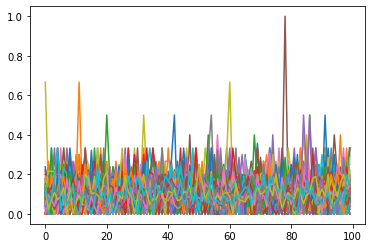

In [108]:
plt.plot(np.array(cc_list).T); 
plt.show()
plt.plot(np.array(cc_list_ein).T);  
plt.show()
plt.plot(np.array(cc_list_for).T);  
plt.show()

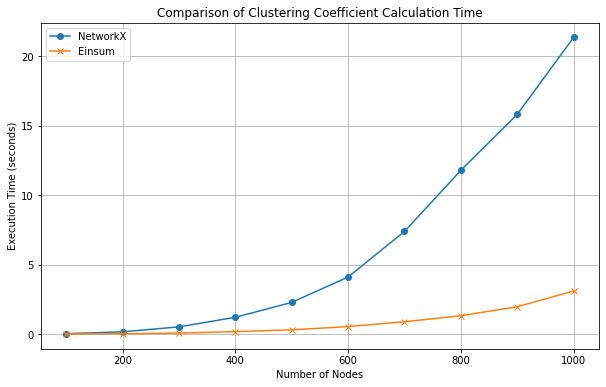

In [138]:
import timeit
# Measure the execution times for both methods across the node range with fewer repetitions
networkx_times = []
einsum_times = []

nodes_range = range(100, 1001, 100)
for n in nodes_range:
    adjacency_matrix_n = genera_ER(n, 1)[0]  #generate_random_adjacency_matrix(n, p)
    G_n = nx.from_numpy_matrix(adjacency_matrix_n)
    
    # Time NetworkX clustering (excluding graph conversion time)
    networkx_time = timeit.timeit(lambda: nx.clustering(G_n), number=3) / 3
    networkx_times.append(networkx_time)
    
    # Time einsum clustering
    einsum_time = timeit.timeit(lambda: cc_einsum(adjacency_matrix_n), number=3) / 3
    einsum_times.append(einsum_time)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(nodes_range, networkx_times, marker='o', linestyle='-', label='NetworkX')
plt.plot(nodes_range, einsum_times, marker='x', linestyle='-', label='Einsum')
plt.xlabel('Number of Nodes')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Clustering Coefficient Calculation Time')
plt.legend()
plt.grid(True)
plt.show()


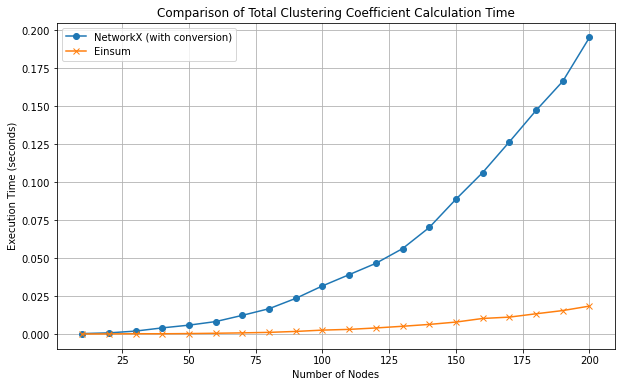

In [139]:
# Define the new range of nodes up to 200
nodes_range = range(10, 201, 10)

# Measure the execution times for both methods across the new node range including graph conversion for NetworkX
networkx_times_with_conversion = []
einsum_times = []

for n in nodes_range:
    adjacency_matrix_n = genera_ER(n, 1)[0]
    
    # Time NetworkX clustering including graph conversion
    networkx_time = timeit.timeit(lambda: nx.clustering(nx.from_numpy_matrix(adjacency_matrix_n)), number=10) / 10
    networkx_times_with_conversion.append(networkx_time)
    
    # Time einsum clustering
    einsum_time = timeit.timeit(lambda: cc_einsum(adjacency_matrix_n), number=10) / 10
    einsum_times.append(einsum_time)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(nodes_range, networkx_times_with_conversion, marker='o', linestyle='-', label='NetworkX (with conversion)')
plt.plot(nodes_range, einsum_times, marker='x', linestyle='-', label='Einsum')
plt.xlabel('Number of Nodes')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Total Clustering Coefficient Calculation Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot Saved Model

In [40]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
from plot_model import plot_model, make_graph
from config_valid import Config
from models import GCN, AutoencoderGCN, ConfModelDecoder
from GridConfigurations import GridConfigurations
from graph_generation import GenerateGraph
from Dataset import Dataset
from train_autoencoder_inductive import Trainer_Autoencoder
from dictionary_of_trials import get_diz_trials
import numpy as np
import torch
import networkx as nx
from torch_geometric.utils.convert import to_networkx, from_networkx


def get_methods(object, spacing=20):
    methodList = []
    for method_name in dir(object):
        try:
            if callable(getattr(object, method_name)):
                methodList.append(str(method_name))
        except Exception:
            methodList.append(str(method_name))
    processFunc = (lambda s: ' '.join(s.split())) or (lambda s: s)
    for method in methodList:
        try:
            print(str(method.ljust(spacing)) + ' ' +
                  processFunc(str(getattr(object, method).__doc__)[0:90]))
        except Exception:
            print(method.ljust(spacing) + ' ' + ' getattr() failed')
            
def sample_from_pij(p_ij):
        pij_shape = p_ij.shape
        assert len(pij_shape) == 2,  f"Non e una matrice. p_ij shape: {pij_shape}"
        adj = np.random.binomial(1, p_ij)
        return adj

In [53]:

#gc = GridConfigurations(config_class, diz_trials)
#gc.make_configs()
#config_class = gc.configs[0]
base_path = Path("output_plots/autoencoder/8/")

path = base_path / "best-Grafi-ER________Classi4_nodi10_________grafiXtipo3____AE_CM__layers§1-64-64-64-32§__ELU__btchnrmSI__-xavier_normal_lr00001_ADAM/model"
path = base_path / "Grafi-ER________Classi4_nodi10_________grafiXtipo3____AE_CM__layers§1-64-64-64-32§__ELU__btchnrmSI__-xavier_normal_lr00002_ADAM/model"
path = base_path / "1_Grafi-ER________Classi4_nodi10_________grafiXtipo3____AE_CM__layers§1-64-64-64-32§__ELU__grphnorm__-xavier_normal_lr0001_SGD/model"
path = base_path / "Grafi-ER________Classi1_nodi5__________grafiXtipo100__AE_CM__layers§1-8-8-8-8§__ELU__grphnorm__-xavier_normal_lr0002_ADAM/model"
path = base_path / "Grafi-ER________Classi1_nodi5__________grafiXtipo100__AE_____layers§1-64-64-64-16§__ELU__grphnorm__-xavier_normal_lr0005_ADAM/model"
path = base_path / "Grafi-ER________Classi1_nodi5__________grafiXtipo300__AE_____layers§1-64-64-64-16§__ELU__grphnorm__-xavier_normal_lr0001_ADAM/model"
path = base_path / "Grafi-ER________Classi9_nodi4__________grafiXtipo30___AE_CM__layers§1-64-64-64-16§__ELU__btchnrmNO__-xavier_normal_lr00005_ADAM/model"
path = base_path / "Grafi-ER________Classi9_nodi4__________grafiXtipo30___AE_CM__layers§1-32-32-16§__ELU__btchnrmNO__-xavier_normal_lr00005_ADAM/model"
path = base_path / "Grafi-ER________Classi9_nodi4__________grafiXtipo30___AE_CM__layers§1-32-32-16§__ELU__btchnrmNO__-xavier_normal_lr00002_ADAM/model"
path = base_path / "Grafi-ER________Classi2_nodi60_________grafiXtipo30___AE_CM__layers§1-32-32-16§__ELU+RELU__btchnrmSI__-xavier_normal_lr00001_ADAM_BCELoss_shflFalse"
path = base_path / "Reg________Classi2_nodi32_________grafiXtipo32___#__AE_CM__§1-8-8-4§__ELU+RELU__grphnorm__-xavier_normal_#__lr0003_ADAM_BCELoss"
path = base_path / "Reg________Classi1_nodi32_________grafiXtipo32___#__AE_CM__§1-8-8-4§__ELU+RELU__grphnorm__-xavier_normal_#__lr0003_ADAM_BCELoss"
path = base_path / "Reg________Classi1_nodi10_________grafiXtipo32___#__AE_CM__§1-8-8-4§__ELU+RELU__btchnrmNO__-xavier_normal_#__lr0003_ADAM_BCELoss"
path = base_path / "ER_________Classi1_nodi3__________grafiXtipo30___#__AE_____§1-8-4§__ELU+Identity__btchnrmNO__-xavier_normal_#__lr001_ADAM_BCELoss"
path = base_path / "ER_________Classi1_nodi100________grafiXtipo100__#__AE_CM__§1-16-16-2§__ELU+RELU__btchnrmNO__-xavier_normal_#__lr0005_ADAM_BCELoss"
path = base_path / "ER__[01]_Classi-1_nodi200_grafiX20___#__AE_CM______§1-16-4§________RELU+RELU__grphnorm__-orthogonal_#__lr0000751_ADAMW_BCELoss"

# recupera la configurazione con cui è stato salvato il modello
config_class, diz_trials = get_diz_trials(path / "config.yml")
trainer = Trainer_Autoencoder(config_class, rootsave=Path(base_path))

model = trainer.init_GCN() 
model.load_state_dict(torch.load(path / "model"))
model.eval()
trainer.model = model
trainer.model.to(trainer.device)
trainer.embedding_dimension = trainer.model.convs[-1].out_channels

trainer.init_dataset()
trainer.load_dataset(trainer.gg.dataset)

primo config base da estendere con i trials validato.
BCELoss()
loss reduction: mean, -> is_weighted: False
Generating dataset...
Dataset generated
Loading Dataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 53.50it/s]


In [54]:
print(next(trainer.model.parameters()).is_cuda)
device="cpu"
trainer.device #dataset.dataset_pyg[0].device

True


device(type='cuda')

Immagine 0 non completata
x and y must have same first dimension, but have shapes (250001,) and (1,)
Traceback (most recent call last):
  File "/home/daniele/Documenti/Progetti/Networks/Embednet/train.py", line 796, in save_image_at_epoch
    fig = plot_metrics(data, self.embedding_dimension,
  File "/home/daniele/Documenti/Progetti/Networks/Embednet/plot_funcs.py", line 544, in plot_metrics
    plot_intrinsic_dimension(ax11, graph_intrinsic_dimensions_total, node_intrinsic_dimensions_total, intr_dim_epoch_list, **kwargs)
  File "/home/daniele/Documenti/Progetti/Networks/Embednet/plot_funcs.py", line 650, in plot_intrinsic_dimension
    ax.semilogx(epochs_list, node_intrinsic_dimensions_total, linestyle='None', marker='.', color='red', label='node id')
  File "/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1817, in semilogx
    return self.plot(
  File "/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/matplotli

(<Metrics.Metrics at 0x7f9bd063b790>, <Metrics.Metrics at 0x7f9b5bcb6760>)

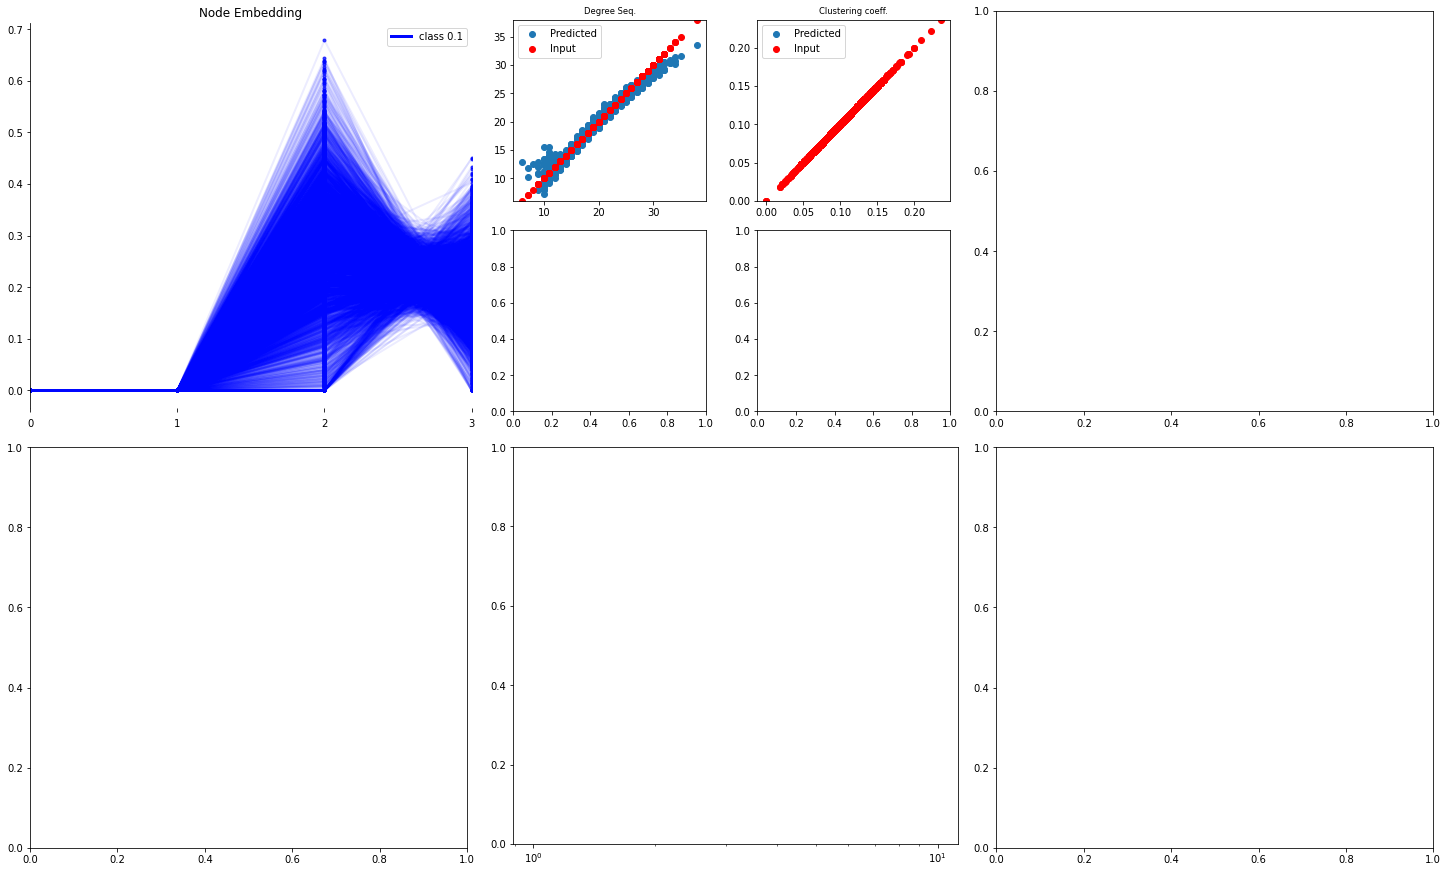

In [55]:
trainer.produce_traning_snapshot(0, False, [], unico_plot=True, notsave=True)

In [ ]:
interv = 15
data_loader = trainer.dataset.all_data_loader
fig, axes = plt.subplots(interv, 2, figsize=(16, 100))
trainer.model.eval()
num_nodes_batch = [len(data.x) for data in data_loader.dataset]
#print(f"num_node_batch = {num_nodes_batch}, batch_size = {data_loader.batch_size}")

i = 0
for data in data_loader:
    total_batch_z, adjusted_pred_adj, input_adj = trainer.encode_decode_inputadj(
                    data, i, data_loader.batch_size, num_nodes_batch)
    
    input_adj = input_adj.detach().cpu().numpy()
    adjusted_pred_adj = adjusted_pred_adj.detach().cpu().numpy()
    
    todislpay = input_adj[:interv]
    for j, input_matrix in enumerate(todislpay):
        if j < interv:
            pred_matrix = adjusted_pred_adj[j]
            #print(pred_matrix)
            out = sample_from_pij(pred_matrix)        
            ggrr = nx.from_numpy_array(out)
            grinp = nx.from_numpy_array(input_matrix)
            cc1 = list(dict(nx.clustering(ggrr)).values())
            cc2 = list(dict(nx.clustering(grinp)).values())
            cc1 = [round(c, 3) for c in cc1]
            cc2 = [round(c,3) for c in cc2]
            #axes[j][0].scatter(cc2,cc1)
            #axes[j][0].scatter(cc2,cc2)
            #nx.draw(grinp, ax=axes[j][0])
            #nx.draw(ggrr, ax=axes[j][1])

    i += data_loader.batch_size

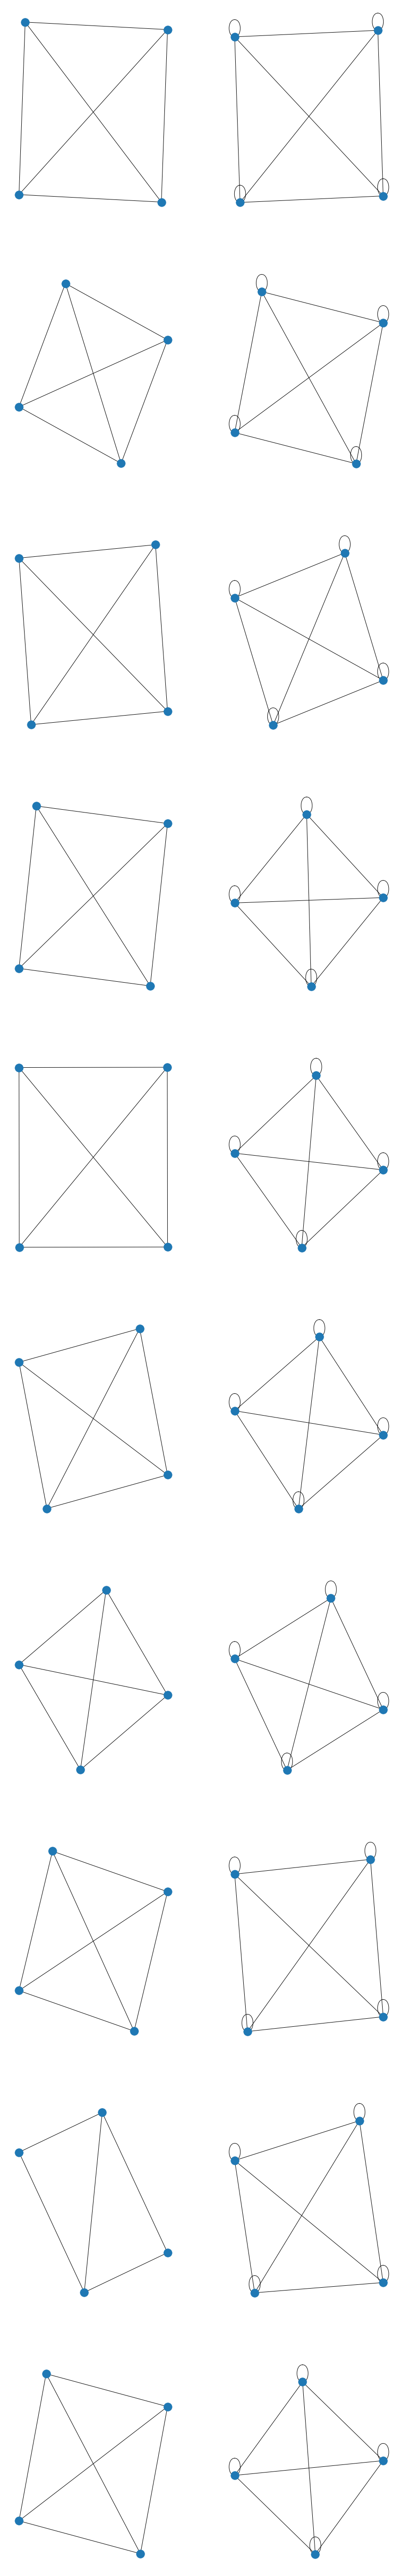

In [56]:
fig, axes = plt.subplots(len(trainer.dataset.dataset_list[:interv]), 2, figsize=(15, 100))
for i, gr in enumerate(trainer.dataset.dataset_list[:interv]):
    nx.draw(gr, ax=axes[i][0])
    pyg_graph = from_networkx(gr)
    trainer.model.eval()
    total_batch_z = trainer.model.encode(pyg_graph.x, pyg_graph.edge_index, pyg_graph.batch)
    adjusted_pred_adj = trainer.calc_decoder_for_batches(total_batch_z, [4]).detach().numpy()
    ggrr = nx.from_numpy_array(adjusted_pred_adj[0])
    nx.draw(ggrr, ax=axes[i][1])
    #plt.show()

(<Metrics.Metrics at 0x7fec46a504f0>, <Metrics.Metrics at 0x7fec46a506d0>)

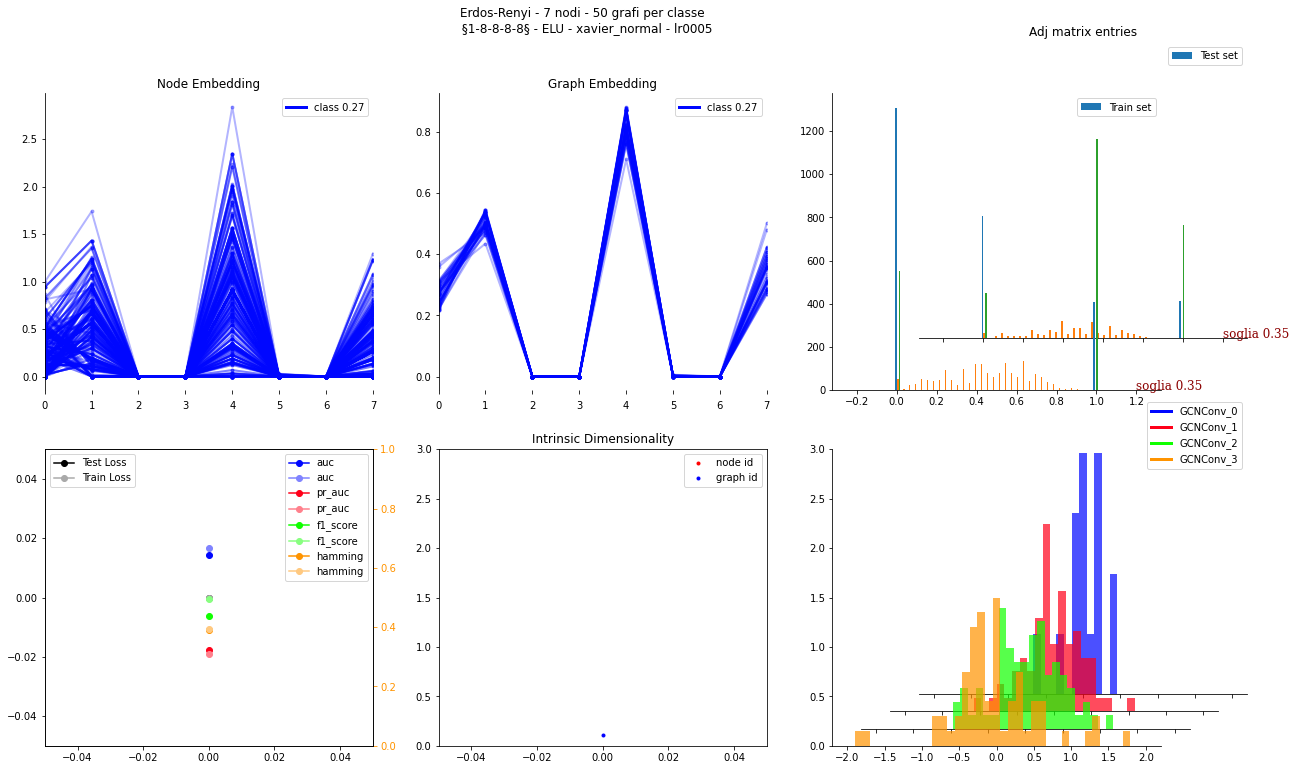

(<Metrics.Metrics at 0x7f68c2faa730>, <Metrics.Metrics at 0x7f68c86756a0>)

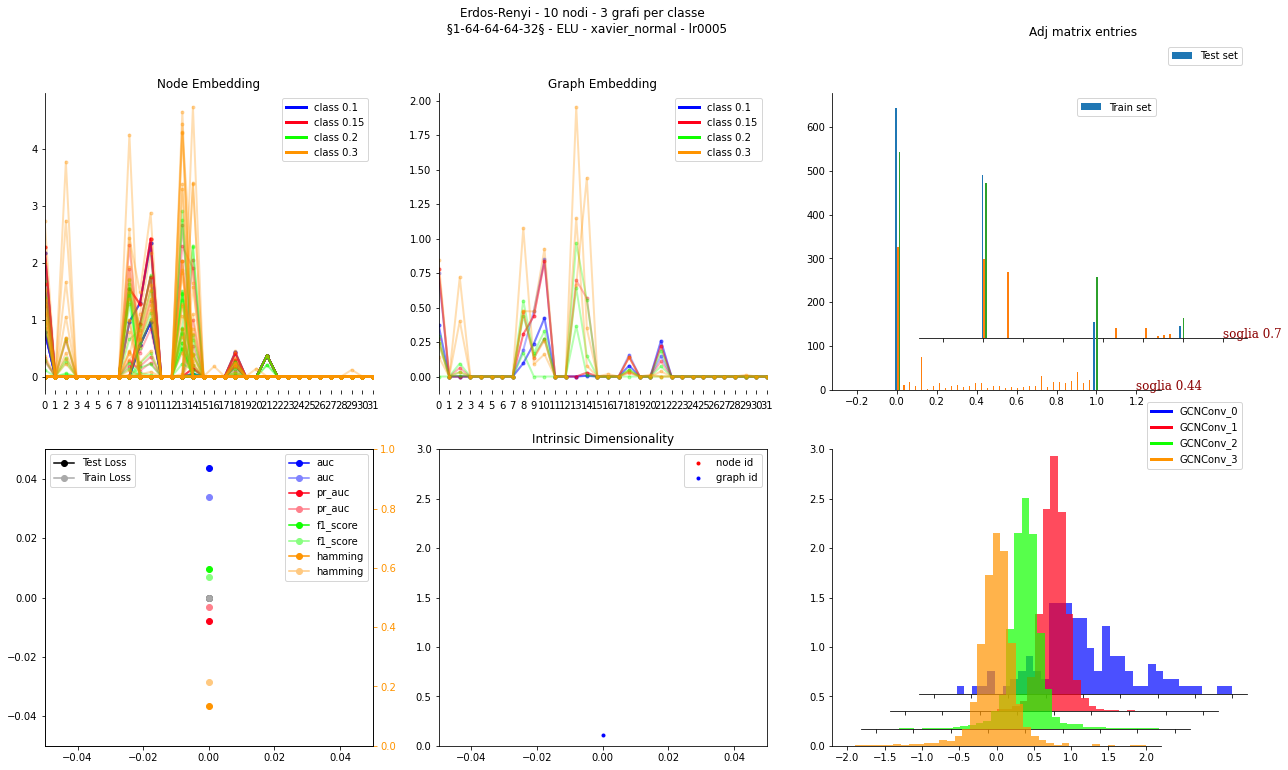

In [29]:
1* 128*64*32, 100*100*15 ,2**45

(262144, 150000, 35184372088832)

In [30]:
def permnodes(N):
    link = (N*(N-1))/2
    return 2**link

list(map(permnodes, [10,9,8,7,6,5,4,3,2]))

[35184372088832.0,
 68719476736.0,
 268435456.0,
 2097152.0,
 32768.0,
 1024.0,
 64.0,
 8.0,
 2.0]

In [ ]:
batch_data = trainer.dataset.sample_dummy_data()
plot = plot_model(trainer.model, batch_data)

In [5]:
traced_model = torch.jit.trace(model, [batch_data.x, batch_data.edge_index])
traced_model.eval()
for p in traced_model.parameters():
    p.requires_grad_(False)

In [ ]:
#d = make_graph(traced_model, classes_to_visit='Sequential')

gr = traced_model.graph
toshow = []
# list(traced_model.graph.nodes())[0]
self_input = next(gr.inputs())
print(self_input)
get_methods(self_input)
self_type = self_input.graphtype().str().split('.')[-1]

In [7]:
type(self_input)

torch._C.Value

In [31]:
import torchvision
m = torchvision.models.resnet18()
m.layer1[0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
d = make_graph(m, classes_to_visit='Sequential')

# Test con grafi ancora più random?

In [1]:
import networkx as nx
from networkx import NetworkXError
import numpy as np
import matplotlib.pyplot as plt

In [114]:
grafi1 = []
grafiCM = []
degrees1 = []
degreesCM = []
num_nodi = 200
int_random = []
#for i in range(1000):
while len(grafiCM) <= 100:
    r = np.random.randint(1,50,num_nodi)
    #print(r)
    try:
        g = nx.havel_hakimi_graph(r)
        gcc = sorted(nx.connected_components(g), key=len, reverse=True)
        gr0 = g.subgraph(gcc[0]).copy()
        grafi1.append(gr0)
        degrees1.extend(np.array(list(dict(gr0.degree()).values()) ))
        
        gcm = nx.configuration_model(r)
        grcm = nx.Graph(gcm)  # remove multiple edges
        grcm.remove_edges_from(nx.selfloop_edges(grcm))  # remove self loops
        gccmm = sorted(nx.connected_components(grcm), key=len, reverse=True)
        grcm0 = grcm.subgraph(gccmm[0]).copy()
        if len(grcm0.nodes()) == num_nodi:
            grafiCM.append(grcm0)
            degreesCM.extend(np.array(list(dict(grcm0.degree()).values()) ))
            int_random.append(r)
        
       
    except NetworkXError as e:
        pass
print(f"{len(grafi1)} grafi HK generati,  con CM: {len(grafiCM)}  è uguale perché serve comunque una sequenza grafica")

101 grafi HK generati,  con CM: 101  è uguale perché serve comunque una sequenza grafica


(array([24., 22., 14., 11., 28., 19., 18., 25., 21., 20., 18., 17., 28.,
        17., 18., 16., 16., 29., 21., 23., 22., 16., 11., 18., 21., 16.,
        20., 22., 17., 11., 24., 23.,  9., 14., 18., 18., 25., 21., 32.,
        23., 17., 23., 22., 21., 28., 20., 24., 15., 20., 24.]),
 array([3.36782844e-04, 2.03214069e-02, 4.03060310e-02, 6.02906551e-02,
        8.02752791e-02, 1.00259903e-01, 1.20244527e-01, 1.40229151e-01,
        1.60213775e-01, 1.80198399e-01, 2.00183024e-01, 2.20167648e-01,
        2.40152272e-01, 2.60136896e-01, 2.80121520e-01, 3.00106144e-01,
        3.20090768e-01, 3.40075392e-01, 3.60060016e-01, 3.80044640e-01,
        4.00029264e-01, 4.20013888e-01, 4.39998512e-01, 4.59983136e-01,
        4.79967761e-01, 4.99952385e-01, 5.19937009e-01, 5.39921633e-01,
        5.59906257e-01, 5.79890881e-01, 5.99875505e-01, 6.19860129e-01,
        6.39844753e-01, 6.59829377e-01, 6.79814001e-01, 6.99798625e-01,
        7.19783249e-01, 7.39767873e-01, 7.59752498e-01, 7.79737122e-

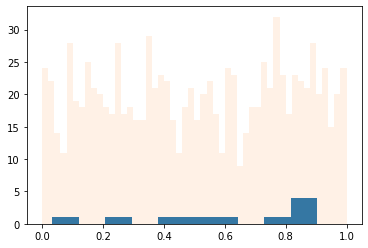

In [12]:
import numpy as np
import matplotlib.pyplot as plt
r = np.random.rand(10)
r2 = np.random.rand(1000)
plt.hist(r)
plt.hist(r2, bins=50, alpha=0.1)

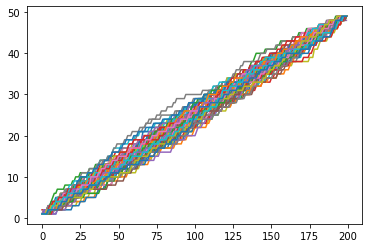

In [115]:
for i in int_random:
    plt.plot(sorted(i))

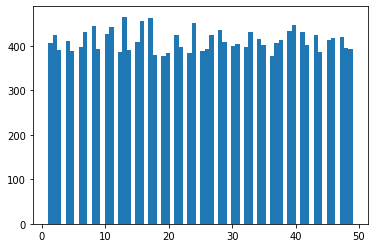

In [117]:
plt.hist(int_random, bins=70);

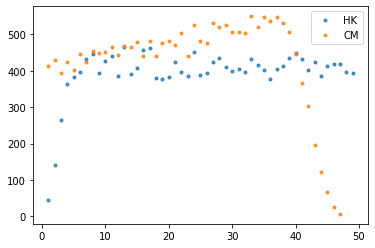

In [118]:
counts1 = np.unique(np.array(degrees1), return_counts=True)
plt.plot(*counts1, '.', alpha=0.8, label="HK");
#plt.show()
countsCM = np.unique(np.array(degreesCM), return_counts=True)
plt.plot(*countsCM, '.' , alpha=0.8, label="CM");
plt.legend()
plt.show()

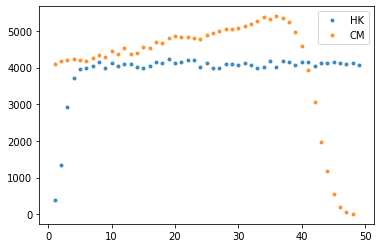

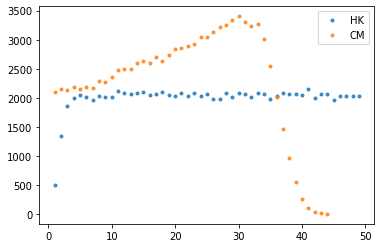

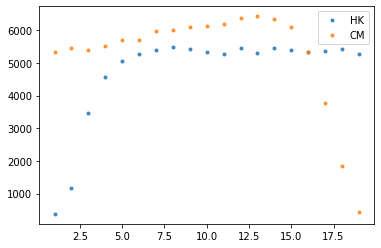

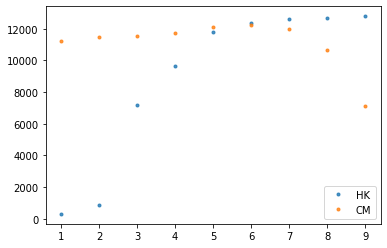

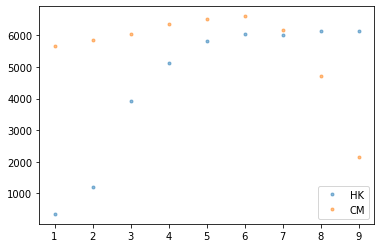

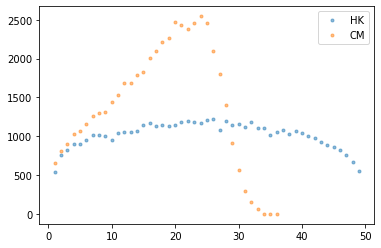

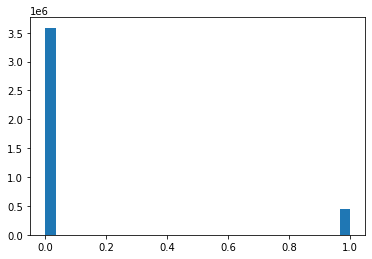

In [119]:
binary_array = np.array([nx.to_numpy_array(g).ravel() for g in grafiCM]).ravel()
plt.hist(binary_array, bins=30);

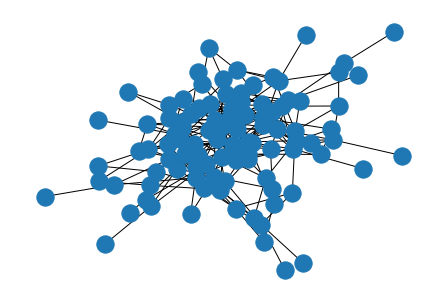

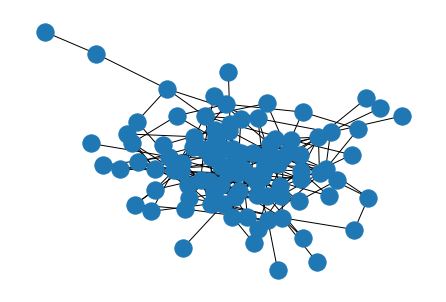

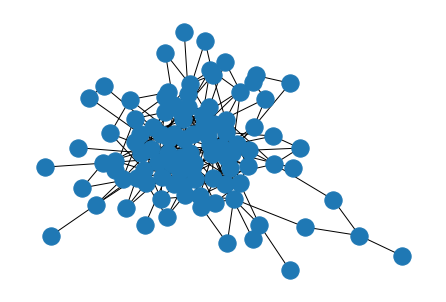

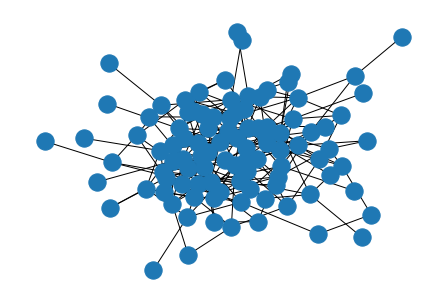

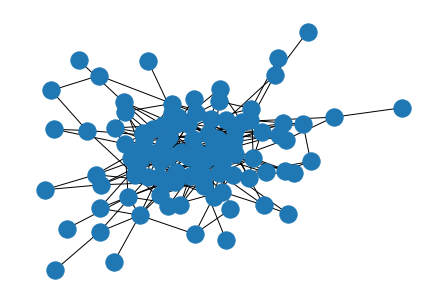

In [15]:
#for g in grafi1[:5]:
#    nx.draw(g)
#    plt.show()
for g in grafiCM[:5]: 
    nx.draw(g)
    plt.show()

# Numero di grafi diversi (non isomorfi) dato il numero di nodi e link

In [1]:
import networkx as nx
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

def generate_all_possible_graphs(num_nodes, num_edges):
    possible_edges = list(combinations(range(num_nodes), 2))
    #print(list(combinations(possible_edges, num_edges)))
    
    all_graphs = []
    
    for edge_combination in combinations(possible_edges, num_edges):
        graph = nx.Graph()
        graph.add_nodes_from(range(num_nodes))
        graph.add_edges_from(edge_combination)
        
        all_graphs.append(graph)
    
    return all_graphs

def count_non_isomorphic(graphs):
    non_iso_count = 0
    for i, G in enumerate(graphs):
        is_iso = False
        for j in range(i):
            if nx.is_isomorphic(G, graphs[j]):
                is_iso = True
                break
        if not is_iso:
            non_iso_count += 1
    return non_iso_count

n = 4  # Number of nodes
k = 3  # Number of edges

def non_iso_graphs(n, k):
    graphs = generate_all_possible_graphs(n, k)
    non_iso_count = count_non_isomorphic(graphs)
    print(f"Number of non-isomorphic graphs with {n} nodes and {k} edges: {non_iso_count}")


In [10]:
n = 4
p = 0.9
average_k = int(p*n)
print(f"numero medio di link con {n} nodi: {average_k}")

numero medio di link con 4 nodi: 3


In [11]:
non_iso_graphs(n,average_k), non_iso_graphs(n,11)

Number of non-isomorphic graphs with 4 nodes and 3 edges: 3
Number of non-isomorphic graphs with 4 nodes and 11 edges: 0


(None, None)

In [19]:
def stats(n,p):
    gr = nx.erdos_renyi_graph(n, p)
    degree_sequence = nx.to_numpy_array(gr).sum(axis=1)
    media_links_per_nodo = degree_sequence.mean()
    std_links_per_nodo = degree_sequence.std()
    
    # controllo eventuali nodi rimasti soli
    Gcc = sorted(nx.connected_components(gr), key=len, reverse=True)
    gr0 = gr.subgraph(Gcc[0]).copy()
    degree_sequence_giant = nx.to_numpy_array(gr0).sum(axis=1)    
    media_links_per_nodo_giant = degree_sequence_giant.mean()
    std_links_per_nodo_giant = degree_sequence_giant.std()
    
    return degree_sequence.sum()/2, media_links_per_nodo, std_links_per_nodo, degree_sequence_giant.sum()/2, media_links_per_nodo_giant, std_links_per_nodo_giant

p = 0.9 # 0.27
for n in range(4,8):
    average_k = round(p*n,2) 
    statistiche = []
    for j in range(2400):
        statistiche.append(stats(n,p))
    statistiche = np.array(statistiche)
    degree_sequence, media_links_per_nodo, std_links_per_nodo, degree_sequence_giant, media_links_per_nodo_giant, std_links_per_nodo_giant = statistiche.T
    degree_sequence = degree_sequence.mean()
    media_links_per_nodo = media_links_per_nodo.mean()
    std_links_per_nodo = std_links_per_nodo.mean()
    degree_sequence_giant = degree_sequence_giant.mean()
    media_links_per_nodo_giant = media_links_per_nodo_giant.mean()
    std_links_per_nodo_giant = std_links_per_nodo_giant.mean()
    print(f"Num link medio con {n} nodi: {average_k} \t\t totale_links: {degree_sequence}, \t link_attuali_media_per_nodo: {round(media_links_per_nodo,2)},\t link_attuali_std_per_nodo: {round(std_links_per_nodo, 2)}")
    print(f"\t\t\t\t\t\t totale_links: {degree_sequence_giant}, \t link_attuali_media_per_nodo: {round(media_links_per_nodo_giant,2)},\t link_attuali_std_per_nodo: {round(std_links_per_nodo_giant, 2)}")
    print("\n")

Num link medio con 4 nodi: 3.6 		 totale_links: 5.397083333333334, 	 link_attuali_media_per_nodo: 2.7,	 link_attuali_std_per_nodo: 0.24
						 totale_links: 5.3966666666666665, 	 link_attuali_media_per_nodo: 2.7,	 link_attuali_std_per_nodo: 0.24


Num link medio con 5 nodi: 4.5 		 totale_links: 9.00125, 	 link_attuali_media_per_nodo: 3.6,	 link_attuali_std_per_nodo: 0.36
						 totale_links: 9.00125, 	 link_attuali_media_per_nodo: 3.6,	 link_attuali_std_per_nodo: 0.36


Num link medio con 6 nodi: 5.4 		 totale_links: 13.50125, 	 link_attuali_media_per_nodo: 4.5,	 link_attuali_std_per_nodo: 0.47
						 totale_links: 13.50125, 	 link_attuali_media_per_nodo: 4.5,	 link_attuali_std_per_nodo: 0.47


Num link medio con 7 nodi: 6.3 		 totale_links: 18.898333333333333, 	 link_attuali_media_per_nodo: 5.4,	 link_attuali_std_per_nodo: 0.56
						 totale_links: 18.898333333333333, 	 link_attuali_media_per_nodo: 5.4,	 link_attuali_std_per_nodo: 0.56




In [89]:
n = 7
average_k = round(p*n,2)
statistiche = []
for j in range(10000):
    statistiche.append(stats(n,p))
statistiche = np.array(statistiche)
degree_sequence, media_links_per_nodo, std_links_per_nodo, degree_sequence_giant, media_links_per_nodo_giant, std_links_per_nodo_giant = statistiche.T
print(f"Num link medio con {n} nodi: {average_k} \t\t totale_links: {degree_sequence.mean()}, \t link_attuali_media_per_nodo: {round(media_links_per_nodo.mean(),2)},\t link_attuali_std_per_nodo: {round(std_links_per_nodo.mean(), 2)}")
print(f"\t\t\t\t\t\t totale_links: {degree_sequence_giant.mean()}, \t link_attuali_media_per_nodo: {round(media_links_per_nodo_giant.mean(),2)},\t link_attuali_std_per_nodo: {round(std_links_per_nodo_giant.mean(), 2)}")

Num link medio con 7 nodi: 1.89 		 totale_links: 11.3094, 	 link_attuali_media_per_nodo: 1.62,	 link_attuali_std_per_nodo: 0.88
						 totale_links: 10.701, 	 link_attuali_media_per_nodo: 1.9,	 link_attuali_std_per_nodo: 0.71


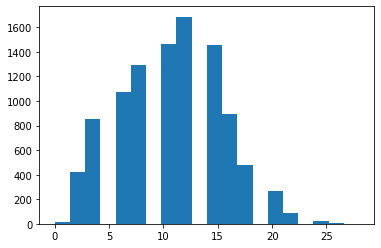

In [98]:
plt.hist(degree_sequence_giant, bins=20);

In [104]:
21*500, 1*64*64*64*32 ,1*32*32*32

(10500, 8388608, 32768)

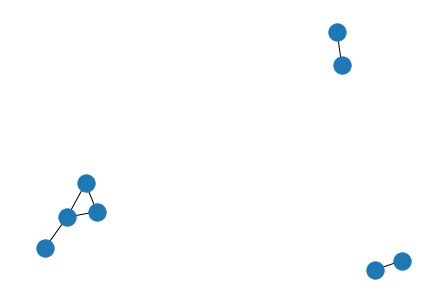

In [49]:
gr = nx.erdos_renyi_graph(8, 0.3)
nx.draw(gr)



In [29]:
nx.to_numpy_array(gr).sum(axis=1)

array([2., 3., 3., 2., 3., 1., 2., 1., 0., 3.])

In [28]:
list(nx.connected_components(gr))

[{0, 1, 2, 3, 4, 5, 6, 7, 9}, {8}]

In [22]:
8*8*8*8

4096

#  sub sub plots

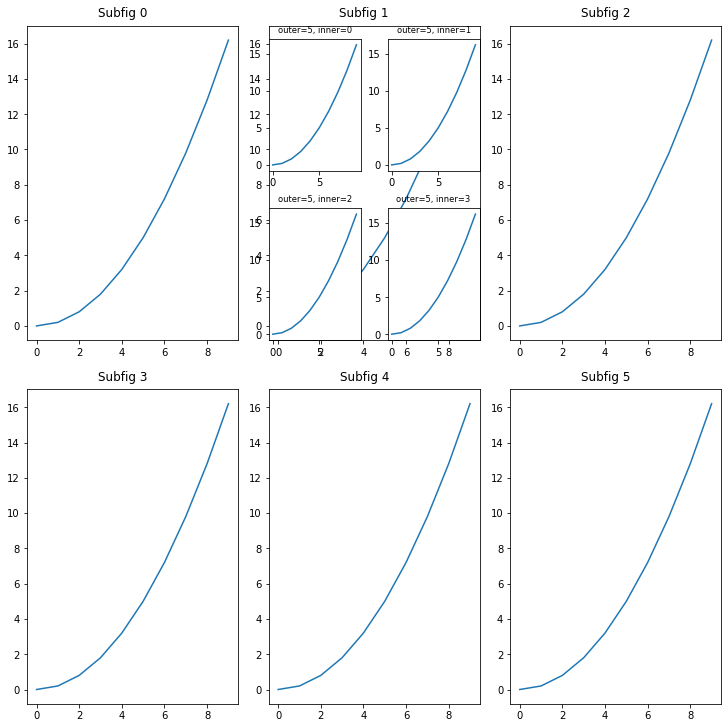

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume we have a DataFrame 'df' with columns 'Date', 'Sales', 'CarType', 'Region'



x = np.arange(10)
y = x*x/5

fig = plt.figure(constrained_layout=True,figsize=(10,10))
subfigs = fig.subfigures(2,3)

for i, fig_i in enumerate(subfigs.flat):
    fig_i.suptitle(f'Subfig {i}')
    ax = fig_i.subplots(1, 1)
    #axa = fig_i.gca()
    #axa.set_title(f'outer={i}', fontsize='small')
    ax.plot(x,y)

axs = subfigs.flat[1].subplots(2,2)
for innerind, ax in enumerate(axs.flat):
        ax.set_title(f'outer={outerind}, inner={innerind}', fontsize='small')
        ax.plot(x,y)



    


plt.show()

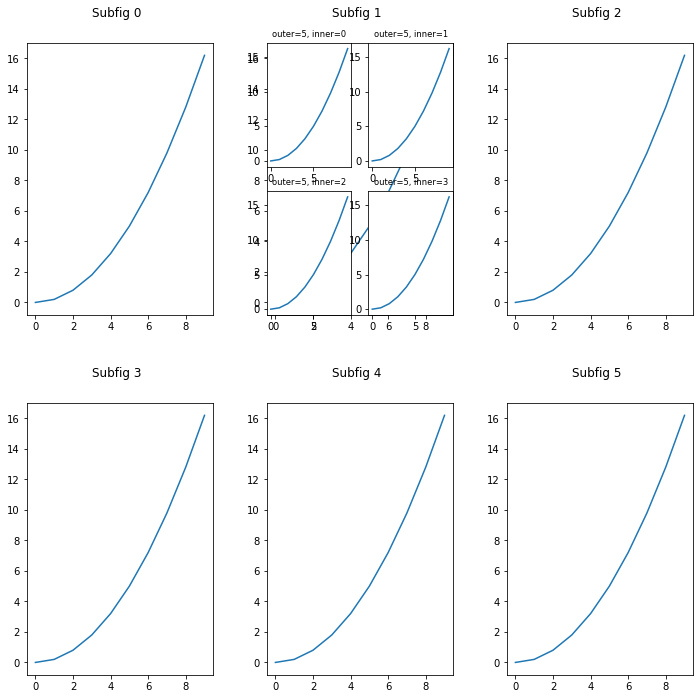

In [38]:
import networkx as nx
G = nx.Graph()
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(1, 3)
G.add_edge(3, 4)
#G.add_edge(3, 3)  

In [39]:
clustering_coefficient = nx.clustering(G)
print(clustering_coefficient)

{1: 1.0, 2: 1.0, 3: 0.3333333333333333, 4: 0}
